# Classification of magnetic phases using a fully-connected neural network

### Machine learning phases of matter

Analysis based on a data set used in the paper *Machine learning phases of matter*, by Juan Carrasquilla & Roger G. Melko, published in *Nature Physics* in 2017: https://www.nature.com/articles/nphys4035

Nature Physics, **13**, 431–434 (2017)

### Data and task description

We consider a 2-dimensional square lattice of $n×n$ magnetic dipole moments (spins) that can be in one of two states (+1 or −1, Ising model). We assume that interactions between spins are of short ranged, i.e. each spin interacts only with its four neighbors. The probability to find a spin in one of the orientations is a function of temperature $T$ according to $ p∼ e^{−a/T} $, where $a=const$.

At very low temperatures $T→0$, neighboring spins have a very low probability of different orientations, so that a uniform overall state (ferromagnetic state) is adopted, characterized by +1 or −1. At very high temperatures $T \rightarrow \infty $, a paramagnetic phase with random spin alignment results, yielding 50% of +1 and 0 of −1 orientations. Below a critical temperature $0<T<T_c$, stable ferromagnetic domains emerge, with both orientations being equally probable in the absence of an external magnetic field. The spin-spin correlations diverge at $T_c$, whereas the correlation decays for $T>T_c$.

The data set for this task contains the $n×n$ dipole orientations on the lattice for different temperatures $T$. The task is to use a fully-connected neural network for classifying the two magnetic phases.

### Import data

In [1]:
import tensorflow as tf
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
callbacks = keras.callbacks
layers = keras.layers


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [2]:
path = r"/Users/murilo/Downloads/Tutorials-20231205/Tutorial 4/ising_data.npz"
f = np.load(path, allow_pickle=True)
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

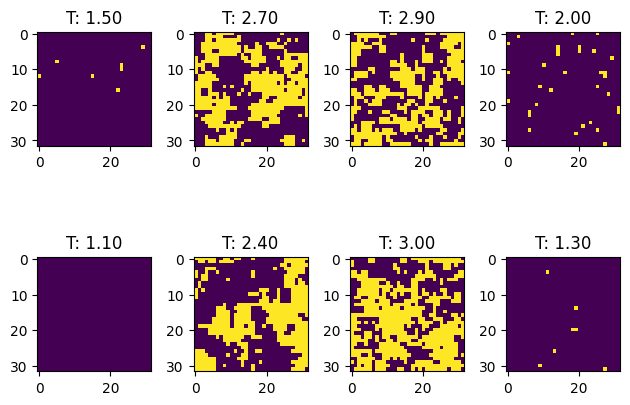

In [3]:
import matplotlib.pyplot as plt

for i,j in enumerate(np.random.choice(n_train, 8)):
    plt.subplot(2,4,i+1)
    image = x_train[j]
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'frequency')

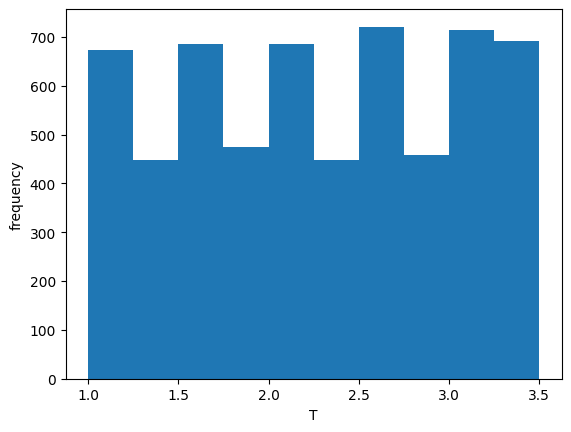

In [4]:
plt.hist(T_test)
plt.xlabel("T")
plt.ylabel("frequency")

#### Definition of magnetic phases in the training set

In [5]:
Tc = 2.27
y_train, y_test = T_train > Tc, T_test > Tc

In [6]:
print(y_train)
print(y_train.shape)
print(x_train.shape)

[ True False False ... False  True  True]
(20000,)
(20000, 32, 32)


### Tasks

- Construct and train a fully-connected neural network (using Keras) for the classification of magnetic phases
- Evaluate the network's performance on the test set
- Plot the test accuracy as function of the temperature. What do you observe?

### The entropy of the system is reaching a more stable state!

In [7]:
nb_layers = 10
nb_nodes = 50

model = Sequential()

model.add(layers.InputLayer(input_shape=(32, 32, 1)))

model.add(layers.Reshape((1024,)))

for i in range(nb_layers - 1):
    model.add(Dense(nb_nodes, activation='relu'))
    
    # Add a dropout layer with a dropout rate of 30% (0.3)
    # Dropout helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
    # This helps to break tight coupling between neurons, making the network more robust and less likely to overfit to the training data.
    model.add(layers.Dropout(0.3))

model.add(Dense(1, activation='linear'))

# Adam:
opt = keras.optimizers.legacy.Adam(learning_rate=0.001) 

# Set loss function and optimiser algorithm
model.compile(loss='mse',  # mean squared error
              optimizer = opt,
              metrics=['accuracy']
             )    

In [8]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=50, 
                    batch_size=128,
                    verbose=2,  # Verbosity mode: 0 = silent, 1 = progress bar, 2 = one line per epoch

                    # Validation data is used to monitor the model's performance on a separate dataset during training
                    validation_split=0.1,
                
                    # List of callbacks to apply during training
                    callbacks=[
                        # EarlyStopping callback monitors a specified metric and stops training if no improvement is seen 
                        # for a certain number of epochs
                        callbacks.EarlyStopping(patience=5, verbose=1),
                
                        # ReduceLROnPlateau callback reduces the learning rate when a metric has stopped improving
                        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)
                    ]
                )

Epoch 1/50
157/157 - 1s - loss: 0.1846 - accuracy: 0.7625 - val_loss: 0.3076 - val_accuracy: 0.4942 - lr: 0.0010 - 718ms/epoch - 5ms/step
Epoch 2/50
157/157 - 0s - loss: 0.1280 - accuracy: 0.8485 - val_loss: 0.3017 - val_accuracy: 0.4942 - lr: 0.0010 - 285ms/epoch - 2ms/step
Epoch 3/50
157/157 - 0s - loss: 0.1130 - accuracy: 0.8737 - val_loss: 0.2879 - val_accuracy: 0.4942 - lr: 0.0010 - 280ms/epoch - 2ms/step
Epoch 4/50
157/157 - 0s - loss: 0.0975 - accuracy: 0.9000 - val_loss: 0.3028 - val_accuracy: 0.4942 - lr: 0.0010 - 317ms/epoch - 2ms/step
Epoch 5/50
157/157 - 0s - loss: 0.0850 - accuracy: 0.9150 - val_loss: 0.2663 - val_accuracy: 0.4953 - lr: 0.0010 - 297ms/epoch - 2ms/step
Epoch 6/50
157/157 - 0s - loss: 0.0736 - accuracy: 0.9298 - val_loss: 0.2810 - val_accuracy: 0.4947 - lr: 0.0010 - 282ms/epoch - 2ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
157/157 - 0s - loss: 0.0647 - accuracy: 0.9400 - val_loss: 0.2834 - val_accuracy: 0.

In [9]:
train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

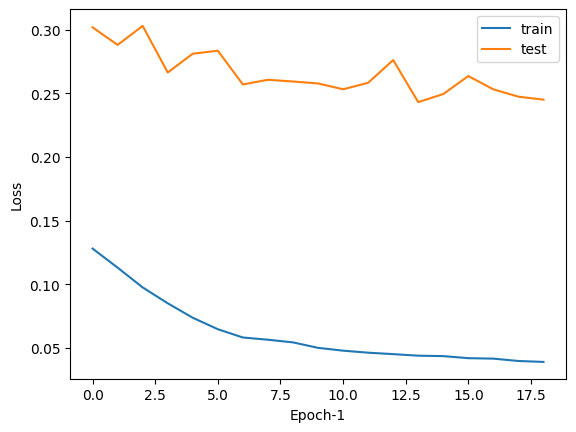

In [10]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.show()

188/188 [==============================] - 0s 398us/step


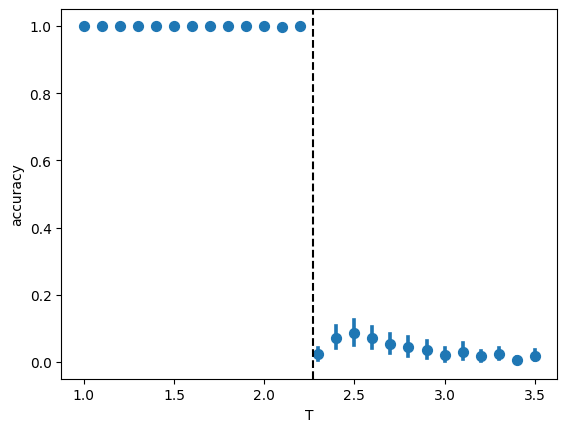

In [11]:
# Import the 'seaborn' library for data visualization
import seaborn as sns

# Evaluate the model on the test data and store the results in 'a'
a = model.evaluate(x_test, y_test, verbose=0)

# Make predictions using the model on the test data, round the predictions, and squeeze the results
preds = model.predict(x_test).round().squeeze()

# Calculate accuracy by comparing the rounded predictions to the true labels
acc = (preds == y_test).astype(float)

# Create a scatter plot with a regression line using 'seaborn'
ax = sns.regplot(x=T_test, y=acc, x_estimator=np.mean, fit_reg=False)

# Set the y-axis label to "accuracy"
ax.set_ylabel("accuracy")

# Set the x-axis label to "T"
ax.set_xlabel("T")

# Add a vertical line at the critical temperature 'Tc' with a dashed line style
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')

### The issue here is the 'linear' activation function in the last layer. Given the binary nature of the output,'sigmoid' is a more suitable choice. It compresses values to [0, 1], making it ideal for binary classification tasks. The 'sigmoid' activation outputs probabilities, simplifying interpretation. Values closer to 1 imply a higher probability of belonging to the positive class, while values closer to 0 suggest a higher likelihood of belonging to the negative class.
### The choice of loss function in model compilation is also a problem. Here, the 'mse' (mean squared error) loss is used, which is appropriate for regression tasks where the goal is to predict continuous values. It calculates the average squared difference between predicted and true values. Alternatively, for binary classification tasks where the output is binary (0 or 1), 'binary_crossentropy' is a more fitting choice. It measures the dissimilarity between the true and predicted distributions, focusing on binary outcomes. The selection between 'mse' and 'binary_crossentropy' should align with the nature of the prediction task: 'mse' for regression and 'binary_crossentropy' for binary classification.

In [12]:
model2 = keras.models.Sequential()
model2.add(layers.InputLayer(input_shape=(32, 32, 1)))

model2.add(layers.Reshape((1024,)))

for i in range(nb_layers - 1):
    model2.add(layers.Dense(nb_nodes, activation='relu'))
    model2.add(layers.Dropout(0.3))


model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dropout_11 (Dropout)        (None, 50)               

In [13]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

In [14]:
results = model2.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=2,  # Verbosity mode: 0 = silent, 1 = progress bar, 2 = one line per epoch

                    # Validation data is used to monitor the model's performance on a separate dataset during training
                    validation_split=0.1,
                
                    # List of callbacks to apply during training
                    callbacks=[
                        # EarlyStopping callback monitors a specified metric and stops training if no improvement is seen 
                        # for a certain number of epochs
                        callbacks.EarlyStopping(patience=5, verbose=1),
                
                        # ReduceLROnPlateau callback reduces the learning rate when a metric has stopped improving
                        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)
                    ]
                )

Epoch 1/50
141/141 - 1s - loss: 0.5069 - accuracy: 0.7714 - val_loss: 0.3775 - val_accuracy: 0.9070 - lr: 1.3501e-04 - 571ms/epoch - 4ms/step
Epoch 2/50
141/141 - 0s - loss: 0.2694 - accuracy: 0.9186 - val_loss: 0.2235 - val_accuracy: 0.9330 - lr: 1.3501e-04 - 232ms/epoch - 2ms/step
Epoch 3/50
141/141 - 0s - loss: 0.1889 - accuracy: 0.9377 - val_loss: 0.2420 - val_accuracy: 0.9400 - lr: 1.3501e-04 - 231ms/epoch - 2ms/step
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.
141/141 - 0s - loss: 0.1694 - accuracy: 0.9414 - val_loss: 0.2336 - val_accuracy: 0.9420 - lr: 1.3501e-04 - 243ms/epoch - 2ms/step
Epoch 5/50
141/141 - 0s - loss: 0.1468 - accuracy: 0.9504 - val_loss: 0.1919 - val_accuracy: 0.9535 - lr: 9.0458e-05 - 244ms/epoch - 2ms/step
Epoch 6/50
141/141 - 0s - loss: 0.1392 - accuracy: 0.9546 - val_loss: 0.2090 - val_accuracy: 0.9550 - lr: 9.0458e-05 - 246ms/epoch - 2ms/step
Epoch 7/50
141/141 - 0s - loss: 0.1289 - accuracy: 0.9554 - val_loss: 0.

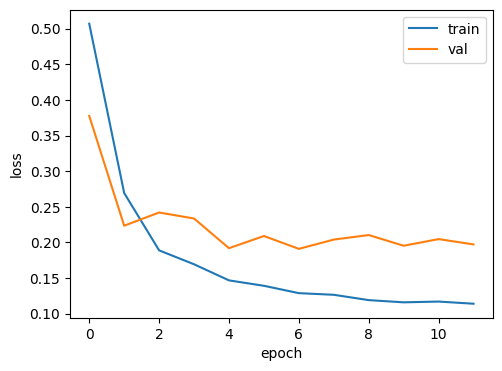

In [15]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

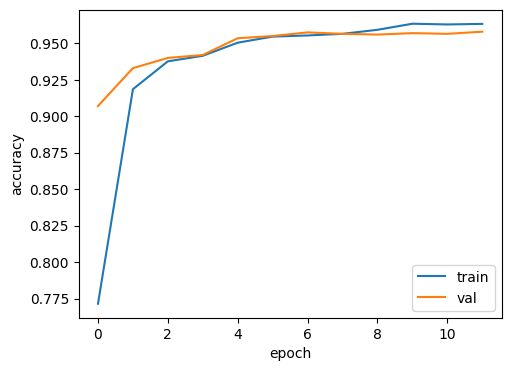

In [16]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

### Model evaluation on the test set

188/188 [==============================] - 0s 439us/step


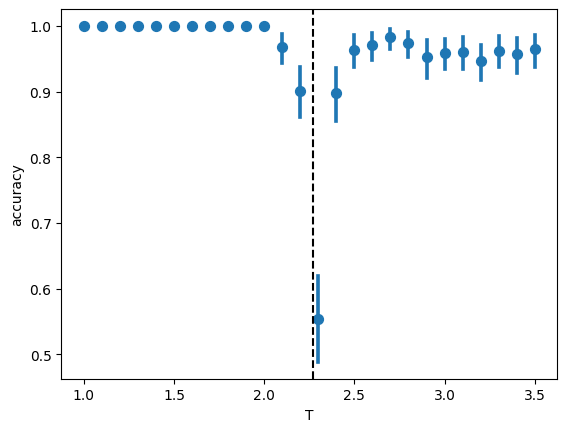

In [17]:
# Import the 'seaborn' library for data visualization
import seaborn as sns

# Evaluate the model on the test data and store the results in 'a'
a = model2.evaluate(x_test, y_test, verbose=0)

# Make predictions using the model on the test data, round the predictions, and squeeze the results
preds = model2.predict(x_test).round().squeeze()

# Calculate accuracy by comparing the rounded predictions to the true labels
acc = (preds == y_test).astype(float)

# Create a scatter plot with a regression line using 'seaborn'
ax = sns.regplot(x=T_test, y=acc, x_estimator=np.mean, fit_reg=False)

# Set the y-axis label to "accuracy"
ax.set_ylabel("accuracy")

# Set the x-axis label to "T"
ax.set_xlabel("T")

# Add a vertical line at the critical temperature 'Tc' with a dashed line style
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')